In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#######
IN_DATA_FNAME = '/data/delon/LensQuEst/map_sims_800x800_20x20.pkl'
DATA_FNAME = '/data/delon/LensQuEst/QE_and_Nhat_from_map_sims_800x800_20x20.pkl'

import warnings
warnings.filterwarnings("ignore")
#####

In [3]:
import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

#to get latex to work, shoulldn't be necessary for most ppl
os.environ['PATH'] = "%s:/usr/local/cuda-11.2/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/anaconda/bin:/home/delon/texlive/bin/x86_64-linux:/home/delon/.local/bin:/home/delon/bin"%os.environ['PATH']

In [37]:
from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
import seaborn as sns
from scipy.stats import spearmanr
import matplotlib

In [5]:
print("Map properties")

# number of pixels for the flat map
nX = 800
nY =800

# map dimensions in degrees
sizeX = 20.
sizeY = 20.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 21  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra

Map properties


In [6]:
print("CMB experiment properties")

# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S3 specs
cmb = StageIVCMB(beam=1.4, noise=7., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: cmb.ftotal(l) 

# reinterpolate: gain factor 10 in speed
L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

CMB experiment properties


In [7]:
print("CMB lensing power spectrum")
u = UnivPlanck15()
halofit = Halofit(u, save=False)
w_cmblens = WeightLensSingle(u, z_source=1100., name="cmblens")
p2d_cmblens = P2dAuto(u, halofit, w_cmblens, save=False)

CMB lensing power spectrum


In [8]:
print("Gets a theoretical prediction for the noise")
fNqCmb_fft = baseMap.forecastN0Kappa(cmb.funlensedTT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)
Ntheory = lambda l: fNqCmb_fft(l) 

Gets a theoretical prediction for the noise
computing the reconstruction noise


In [9]:
f = open(IN_DATA_FNAME, 'rb') 
in_data = pickle.load(f) 
f.close()
for key in in_data:
    print(key, np.shape(in_data[key]))

cmb0F_1 (100, 800, 401)
kCmbF_1 (100, 800, 401)
lCmbF_1 (100, 800, 401)
lCmbF_o1_1 (100, 800, 401)
lCmbF_o2_1 (100, 800, 401)
lCmbF_o3_1 (100, 800, 401)
lCmbF_o4_1 (100, 800, 401)
fgF_1 (100, 800, 401)
noiseF_1 (100, 800, 401)
totalF_1 (100, 800, 401)
totalF_0 (100, 800, 401)


In [10]:
pairs = [
    [0,0], #N0
    [0,1], #kappa
    [1,0], #kappa
    [1,1], #N1
    [0,2], #N1
    [2,0], #N1
    [-1, -1], #QE
    [-2, -2], #unlensed
]

data_names = {
    0: 'cmb0F_1',
    1: 'lCmbF_o1_1',
    2: 'lCmbF_o2_1',
    -1: 'lCmbF_1',
    -2: 'totalF_0',
}

In [11]:
f = open(DATA_FNAME, 'rb') 
data = pickle.load(f) 
f.close()
for key in data:
    print(key, np.shape(data[key]))

00 (100, 800, 401)
00_sqrtN (100, 800, 401)
01 (100, 800, 401)
01_sqrtN (0,)
10 (100, 800, 401)
10_sqrtN (0,)
11 (100, 800, 401)
11_sqrtN (100, 800, 401)
02 (100, 800, 401)
02_sqrtN (0,)
20 (100, 800, 401)
20_sqrtN (0,)
-1-1 (100, 800, 401)
-1-1_sqrtN (100, 800, 401)
-2-2 (100, 800, 401)
-2-2_sqrtN (100, 800, 401)


In [12]:
ps_data = {}

In [13]:
#estimate N0
ck = 'N0'

for data_idx in range(len(data['00'])):
    q00 = data['00'][data_idx]
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=q00)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((np.array([c_ps_data[ck]]), ps_data[ck]))  

In [14]:
#estimate kk
ck = 'kk'


for data_idx in range(min(len(data['01']), len(data['10']))):
    q01 = data['01'][data_idx]
    q10 = data['10'][data_idx]
    kCmbFourier = in_data['kCmbF_1'][data_idx]
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.crossPowerSpectrum(dataFourier1=q10+q01, dataFourier2=kCmbFourier)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((np.array([c_ps_data[ck]]), ps_data[ck]))  

In [15]:
#estimate N1
ck = 'N1'

for data_idx in range(min(len(data['00']), len(data['02']),len(data['20']),len(data['11']))):
    q02 = data['02'][data_idx]
    q20 = data['20'][data_idx]
    q00 = data['00'][data_idx]
    q11 = data['11'][data_idx]
    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.crossPowerSpectrum(dataFourier1=q00, 
                                                                                      dataFourier2=2*(q11+q02+q20))
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((np.array([c_ps_data[ck]]), ps_data[ck]))  

In [16]:
#estimate <QE QE>
ck = 'QEQE'
for data_idx in range(len(data['-1-1'])):
    QE = data['-1-1'][data_idx]
    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=QE)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((np.array([c_ps_data[ck]]), ps_data[ck]))  

In [17]:
#estimate <QE QE>
ck = 'Nhat'
for data_idx in range(len(data['-1-1_sqrtN'])):
    sqrtNhat = data['-1-1_sqrtN'][data_idx]
    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=sqrtNhat)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((np.array([c_ps_data[ck]]), ps_data[ck]))  

In [18]:
def combine_Cl(Cls_tot):
    n_runs = np.shape(Cls_tot)[0]
    print(n_runs, np.shape(Cls_tot))
    lCen = Cls_tot[0][0]
    Cls = np.sum(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)/n_runs
    sCls = np.sqrt(np.sum(np.square(np.transpose(Cls_tot, axes=[1,2,0])[2]), axis=1))/n_runs
    return lCen, Cls, sCls

def combine_sketchy(Cl0, Cli):
    n_runs = np.shape(Cl0)[0]
    print(n_runs, np.shape(Cl0))
    ret = np.copy(Cl0)
    ret = np.transpose(ret, axes=[1,2,0])
    ret[1] = np.array([
        [Cl0[run_idx][1][bin_idx]+
         sum([Cli[i][run_idx][1][bin_idx] for i in range(len(Cli))]) 
                     for run_idx in range(n_runs)] 
                    for bin_idx in range(len(Cl0[0][1]))])
    ret[2] = np.array([[np.sqrt(Cl0[run_idx][2][bin_idx]**2+sum([Cli[i][run_idx][2][bin_idx]**2 
                                                               for i in range(len(Cli))]))
                     for run_idx in range(n_runs)] 
                    for bin_idx in range(len(Cl0[0][1]))])
    return np.transpose(ret, axes=[2,0,1])

In [19]:
ps_data['N2+'] = combine_sketchy(ps_data['QEQE'], [-ps_data['N0'], -ps_data['kk'], -ps_data['N1']])
ps_data['N1+'] = combine_sketchy(ps_data['QEQE'], [-ps_data['N0'], -ps_data['kk']])
ps_data['KK+N1+'] = combine_sketchy(ps_data['kk'], [ps_data['N1+']])


100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)


In [20]:
ps_data['QEQE-Nhat'] = combine_sketchy(ps_data['QEQE'], [-ps_data['Nhat']])

100 (100, 3, 50)


100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)


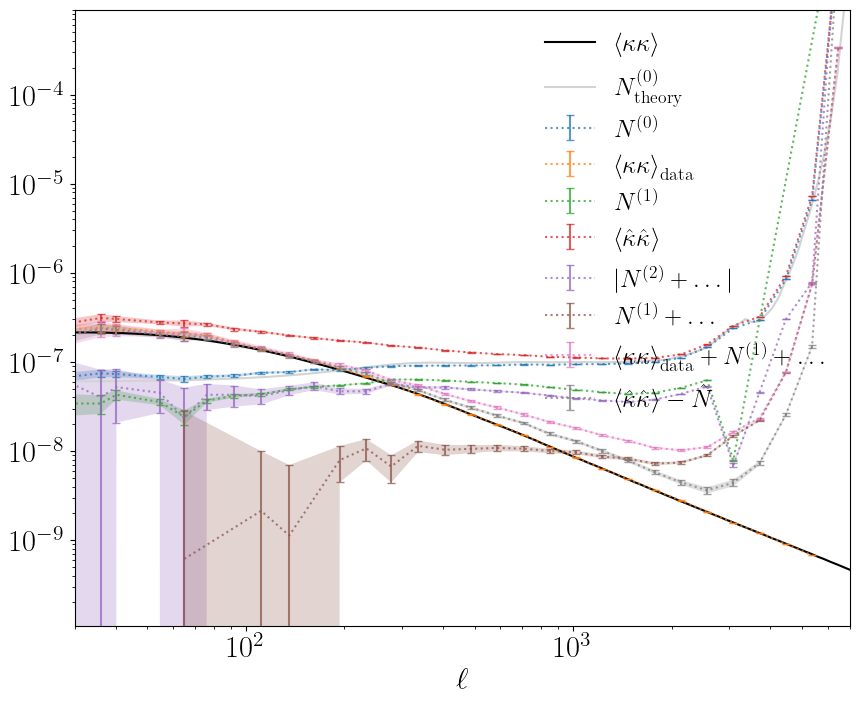

In [21]:
labels={
    'N0':r'$N^{(0)}$',
    'kk':r'$\left<\kappa\kappa\right>_{\rm data}$',
    'N1':r'$N^{(1)}$',
    'N2+':r'$|N^{(2)}+\dots|$',
    'QEQE':r'$\left<\hat\kappa\hat\kappa\right>$',
    'QEQE-Nhat':r'$\left<\hat\kappa\hat\kappa\right>-\hat N$',
    'Nhat':r'$\hat N$',
    'N1+':r'$N^{(1)}+\dots$',
    'KK+N1+': r'$\left<\kappa\kappa\right>_{\rm data}+N^{(1)}+\dots$',
}



fig,ax = plt.subplots(nrows=1, figsize=(10,8))

ell = baseMap.l.flatten()
theory=[p2d_cmblens.fPinterp, Ntheory]
theory_l=[r'$\big<\kappa\kappa\big>$', r'$N^{(0)}_{\rm theory}$']
theory_s=['black', 'lightgrey']
for f,l,sty in zip(theory, theory_l, theory_s):
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))
    ax.plot(L, ClExpected, sty, label=l)

    


for key in ps_data:
    lCen, Cl, sCl = combine_Cl(np.array(ps_data[key]))
    if(key=='Nhat'):
        continue
    if(key=='N2+'):
        Cl = np.abs(Cl)
#     if(key=='N2+'):
#         print(Cl)


    Ipos = np.where(Cl>=1e-30)
    
    ax.errorbar(lCen[Ipos], (Cl[Ipos]), yerr=sCl[Ipos], alpha=.75, 
                fmt=':', capsize=3, capthick=1, label=labels[key])
    tmp_data = {
        'x': lCen[Ipos],
        'y1': [y - e for y, e in zip((Cl[Ipos]), sCl[Ipos])],
        'y2': [y + e for y, e in zip((Cl[Ipos]), sCl[Ipos])]}
    ax.fill_between(**tmp_data,  alpha=.25)


ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_yscale('log')
ax.set_xlim(lMin,2*lMax)
ax.set_ylim(1.1e-10,.9e-3)

plt.savefig('figures/Ni_decomposed.pdf', bbox_inches='tight')

In [77]:
def graph_from_keys(c_keys, offset=0.03):
    
    
    offsets = dict(zip(c_keys,[i*offset for i in range(len(c_keys))]))


    fig,ax = plt.subplots(nrows=1, figsize=(11,8))

    ell = baseMap.l.flatten()
    theory=[p2d_cmblens.fPinterp, Ntheory]
    theory_l=[r'$\big<\kappa\kappa\big>$', r'$N^{(0)}_{\rm theory}$']
    theory_s=['black', 'lightgrey']
    for f,l,sty in zip(theory, theory_l, theory_s):
        L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
        ClExpected = np.array(list(map(f, L)))
        ax.plot(L, ClExpected, sty, label=l)

    for key in c_keys:
        lCen, Cl, sCl = combine_Cl(np.array(ps_data[key]))
        if(key=='N2+'):
            Cl = np.abs(Cl)
    #     if(key=='N2+'):
    #         print(Cl)
    
        offset = offsets[key]
        tmp = [l*np.exp(offset)-l for l in lCen]
        lCen += tmp

        Ipos = np.where(Cl>=1e-30)

        ax.errorbar(lCen[Ipos], (Cl[Ipos]), yerr=sCl[Ipos], alpha=.75, 
                    fmt=':', capsize=3, capthick=1, label=labels[key])
        tmp_data = {
            'x': lCen[Ipos],
            'y1': [y - e for y, e in zip((Cl[Ipos]), sCl[Ipos])],
            'y2': [y + e for y, e in zip((Cl[Ipos]), sCl[Ipos])]}
        ax.fill_between(**tmp_data,  alpha=.25)


    ax.legend(frameon=False)
    ax.set_xscale('log')
    ax.set_xlabel(r'$\ell$')
    ax.set_yscale('log')
    ax.set_xlim(lMin,2*lMax)
    ax.set_ylim(1.1e-10,.9e-3)
    return fig, ax

100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)


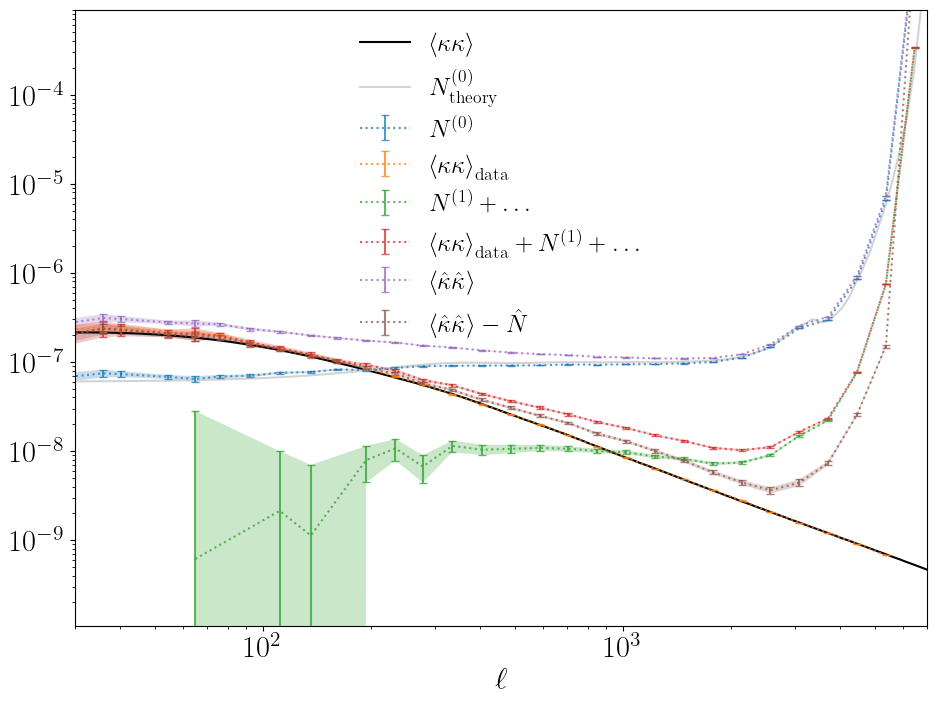

In [78]:
graph_from_keys([
    'N0',
    'kk',
    'N1+',
    'KK+N1+',
    'QEQE',
    'QEQE-Nhat',
], offset=0)
plt.savefig('figures/Ni_decomposed_cleaner.pdf')

100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)


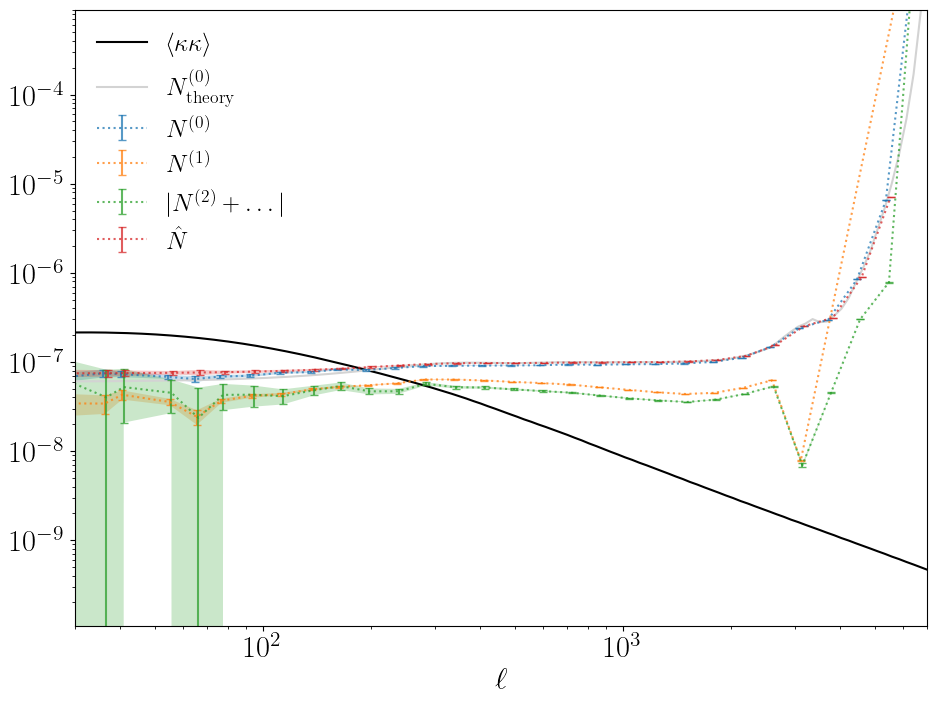

In [79]:
graph_from_keys([
    'N0',
    'N1',
    'N2+',
    'Nhat'
], offset=0.01)
plt.savefig('figures/Ni_decomposed_just_N.pdf')

100 (100, 3, 50)
100 (100, 3, 50)


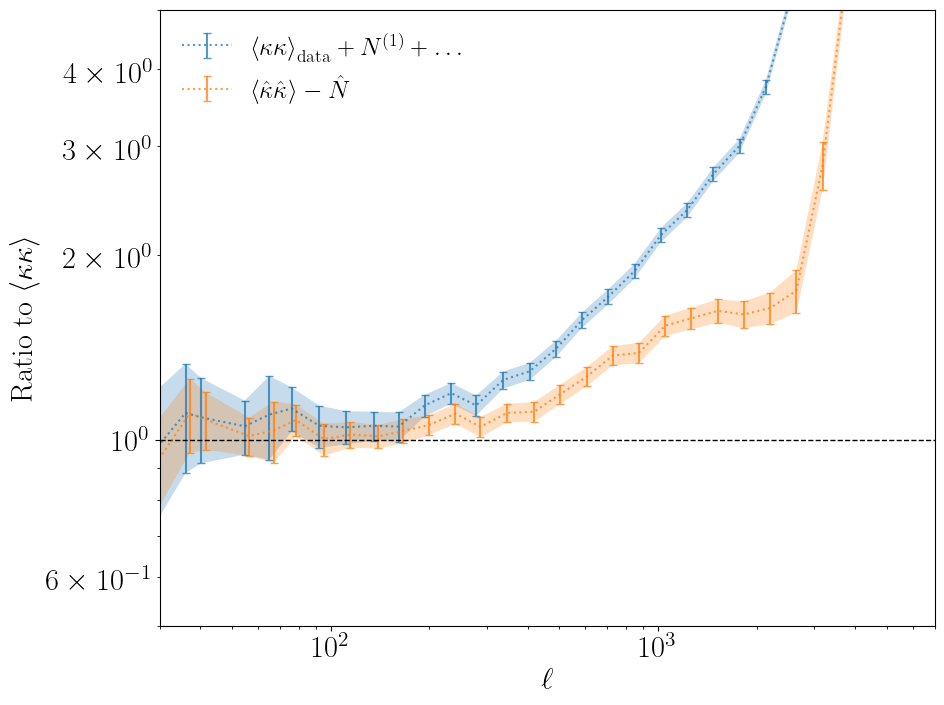

In [74]:
fig,ax = plt.subplots(nrows=1, figsize=(10,8))

c_keys = [
    'KK+N1+',
    'QEQE-Nhat'
]

offsets = dict(zip(c_keys,[0,0.03]))
for key in c_keys:
    lCen, Cl, sCl = combine_Cl(np.array(ps_data[key]))
    
    kk_true = np.array([p2d_cmblens.fPinterp(l) for l in lCen])
    
    Cl /= kk_true
    sCl /= kk_true
    offset = offsets[key]
    tmp = [l*np.exp(offset)-l for l in lCen]
    lCen += tmp

    Ipos = np.where(Cl>=1e-30)
    
    ax.errorbar(lCen[Ipos], (Cl[Ipos]), yerr=sCl[Ipos], alpha=.75, 
                fmt=':', capsize=3, capthick=1, label=labels[key])
    tmp_data = {
        'x': lCen[Ipos],
        'y1': [y - e for y, e in zip((Cl[Ipos]), sCl[Ipos])],
        'y2': [y + e for y, e in zip((Cl[Ipos]), sCl[Ipos])]}
    ax.fill_between(**tmp_data,  alpha=.25)


ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel(r'Ratio to $\left<\kappa\kappa\right>$')

ax.set_xlabel(r'$\ell$')
ax.set_xlim(lMin,2*lMax)
ax.set_ylim(0.5,5)
plt.axhline(1, linewidth=1, linestyle="--", color="black")
plt.savefig('figures/Ni_decomposed_ratios.pdf', bbox_inches='tight')

100 (100, 3, 50)
100 (100, 3, 50)


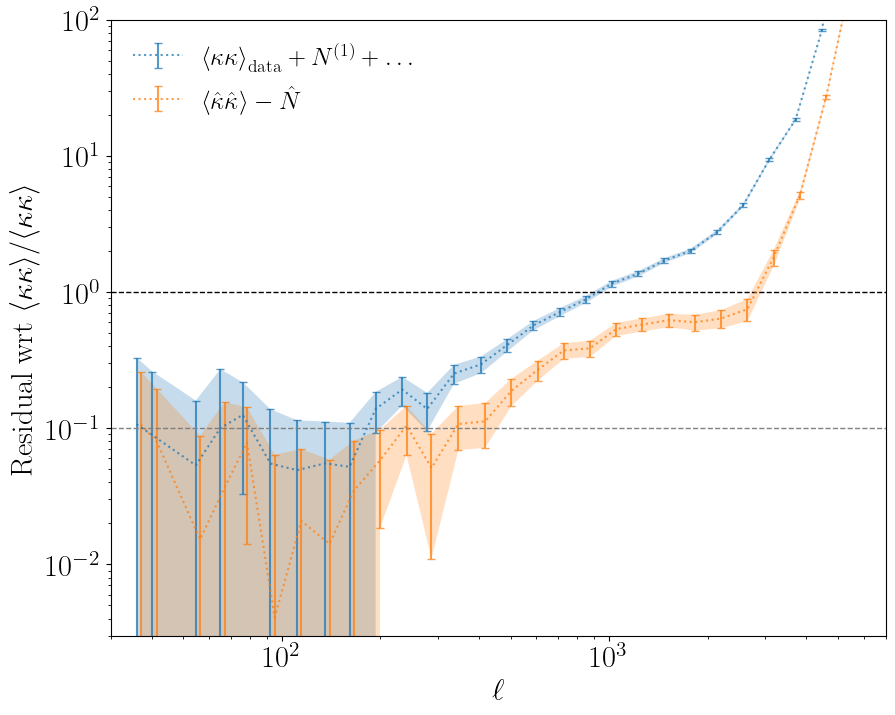

In [73]:
fig,ax = plt.subplots(nrows=1, figsize=(10,8))

c_keys = [
    'KK+N1+',
    'QEQE-Nhat'
]

offsets = dict(zip(c_keys,[0,0.03]))
for key in c_keys:
    lCen, Cl, sCl = combine_Cl(np.array(ps_data[key]))
    
    kk_true = np.array([p2d_cmblens.fPinterp(l) for l in lCen])
    
    Cl -= kk_true
    Cl /= kk_true
    sCl /= kk_true
    
    offset = offsets[key]
    tmp = [l*np.exp(offset)-l for l in lCen]
    lCen += tmp

    Ipos = np.where(Cl>=1e-30)
    
    ax.errorbar(lCen[Ipos], (Cl[Ipos]), yerr=sCl[Ipos], alpha=.75, 
                fmt=':', capsize=3, capthick=1, label=labels[key])
    tmp_data = {
        'x': lCen[Ipos],
        'y1': [y - e for y, e in zip((Cl[Ipos]), sCl[Ipos])],
        'y2': [y + e for y, e in zip((Cl[Ipos]), sCl[Ipos])]}
    ax.fill_between(**tmp_data,  alpha=.25)


ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_ylabel(r'Residual wrt $\left<\kappa\kappa\right>$/$\left<\kappa\kappa\right>$')

# ax.set_yscale(matplotlib.scale.SymmetricalLogScale(ax, linthresh=1e-10))
ax.set_yscale('log')


ax.set_xlabel(r'$\ell$')
ax.set_xlim(lMin,2*lMax)
ax.set_ylim(.3e-2,1e2)
plt.axhline(1, linewidth=1, linestyle="--", color="black")
plt.axhline(.1, linewidth=1, linestyle="--", color="gray")

plt.savefig('figures/Ni_decomposed_residual.pdf', bbox_inches='tight')